In [ ]:
from corgisim import scene
from corgisim import instrument
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import proper
import roman_preflight_proper
roman_preflight_proper.copy_here()

c:\Users\28908\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Vmag = 8
sptype = 'G0V'
cgi_mode = 'excam'
bandpass_corgisim = '1F'
cor_type = 'hlc'
output_dim = 51 #201 for SPC-wide, 51 for HLC

mag_companion = 25
companion_x_pos = 148
companion_y_pos = 148
companion_pol = np.array([1, 0.4, 0, 0])

host_star_properties = {'Vmag': Vmag, 'spectral_type': sptype, 'magtype':'vegamag'}
point_source_info = [{'Vmag': mag_companion, 'magtype': 'vegamag','position_x':companion_x_pos , 'position_y':companion_y_pos, 'pol_state': companion_pol}]
base_scene = scene.Scene(host_star_properties, point_source_info)

cases = ['3e-8']       
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )

proper_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
   
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=1, proper_keywords=proper_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf_polarized(base_scene)
image_star_corgi_horizontal = sim_scene.host_star_image[0].data
image_star_corgi_vertical = sim_scene.host_star_image[1].data
sim_scene = optics.inject_point_sources_polarized(base_scene, sim_scene)
image_comp_corgi_horizontal = sim_scene.point_source_image[0].data
image_comp_corgi_vertical = sim_scene.point_source_image[1].data
image_tot_corgi_horizontal = image_star_corgi_horizontal + image_comp_corgi_horizontal
image_tot_corgi_vertical = image_star_corgi_vertical + image_comp_corgi_vertical

Adding 1 off-axis sources
CorgiOptics initialized with proper keywords.


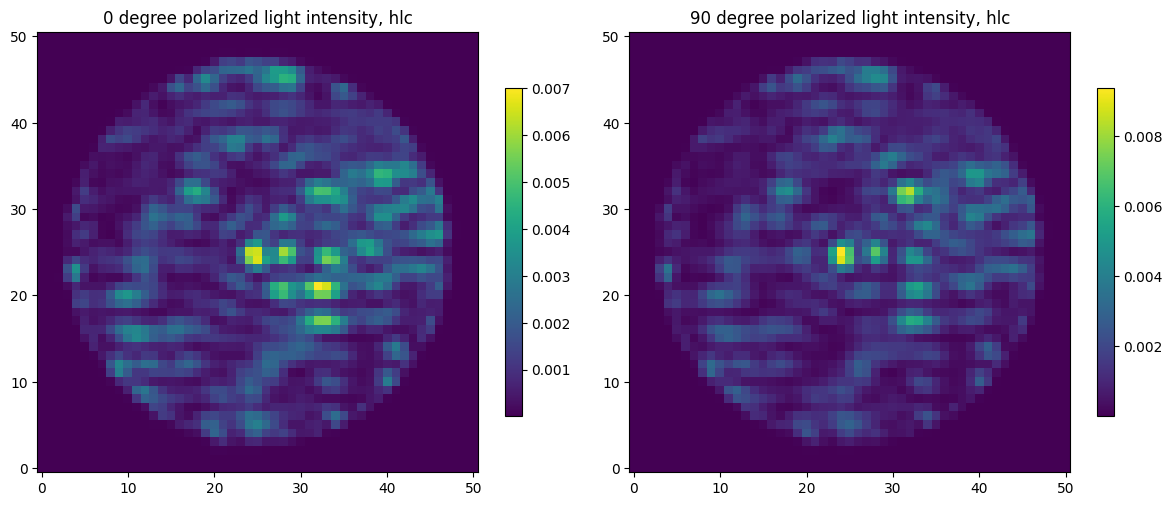

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image
im1 = axes[0].imshow(image_tot_corgi_horizontal, origin='lower')
axes[0].set_title('0 degree polarized light intensity, hlc')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

# Plot the second image (replace image2 with your second image array)
im2 = axes[1].imshow(image_tot_corgi_vertical, origin='lower')  # Optional: adjust origin if needed
axes[1].set_title('90 degree polarized light intensity, hlc')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()

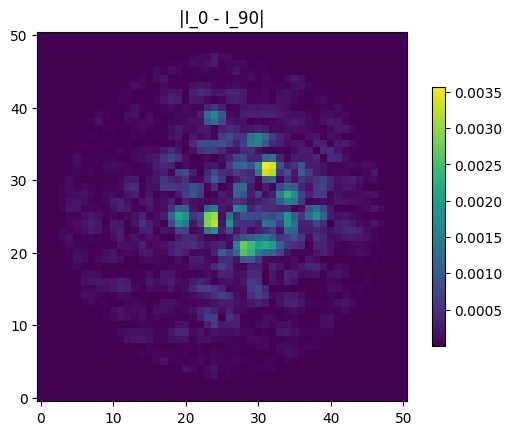

In [4]:
plt.imshow(np.abs(image_tot_corgi_horizontal - image_tot_corgi_vertical), origin='lower')
plt.title('|I_0 - I_90|')

co = plt.colorbar(shrink=0.7)

In [5]:
proper_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=2, proper_keywords=proper_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf_polarized(base_scene)
image_star_corgi_45 = sim_scene.host_star_image[0].data
image_star_corgi_135 = sim_scene.host_star_image[1].data
sim_scene = optics.inject_point_sources_polarized(base_scene, sim_scene)
image_comp_corgi_45 = sim_scene.point_source_image[0].data
image_comp_corgi_135 = sim_scene.point_source_image[1].data
image_tot_corgi_45 = image_star_corgi_45 + image_comp_corgi_45
image_tot_corgi_135 = image_star_corgi_135 + image_comp_corgi_135

CorgiOptics initialized with proper keywords.


C:\Users\28908\OneDrive\文档\CorGi\corgisim\corgisim\instrument.py:299: UserWarning: Warning: 45°/135° polarized images for the speckle field is currently unsupported, generated output will not be accurate
  warnings.warn('Warning: 45°/135° polarized images for the speckle field is currently unsupported, generated output will not be accurate')


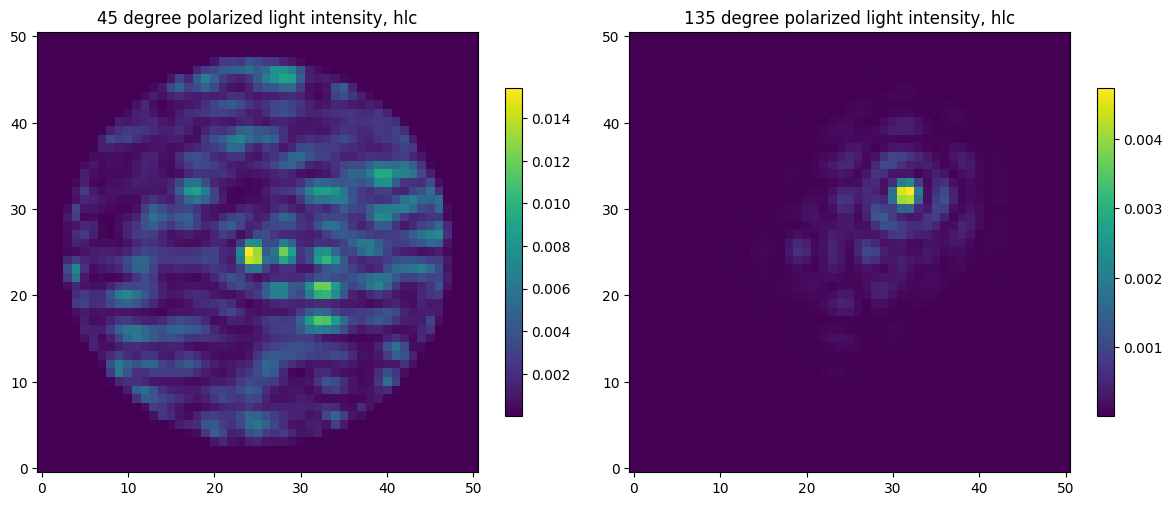

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image
im1 = axes[0].imshow(image_tot_corgi_45, origin='lower')
axes[0].set_title('45 degree polarized light intensity, hlc')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

# Plot the second image (replace image2 with your second image array)
im2 = axes[1].imshow(image_tot_corgi_135, origin='lower')  # Optional: adjust origin if needed
axes[1].set_title('135 degree polarized light intensity, hlc')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()

In [7]:
proper_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=0, proper_keywords=proper_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf(base_scene)
image_star_corgi_unpol = sim_scene.host_star_image.data
sim_scene = optics.inject_point_sources(base_scene, sim_scene)
image_comp_corgi_unpol = sim_scene.point_source_image.data
image_tot_corgi_unpol = image_star_corgi_unpol + image_comp_corgi_unpol

CorgiOptics initialized with proper keywords.


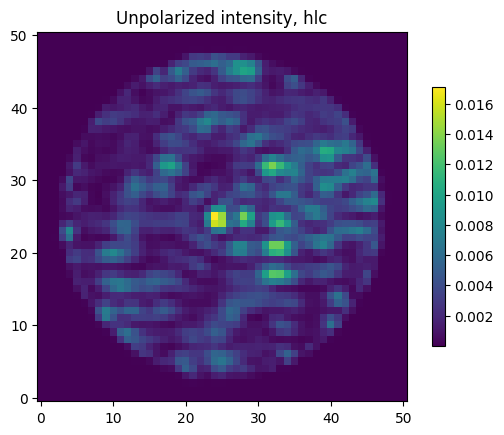

In [8]:
plt.imshow(image_tot_corgi_unpol, origin='lower')
plt.title('Unpolarized intensity, hlc')

co = plt.colorbar(shrink=0.7)

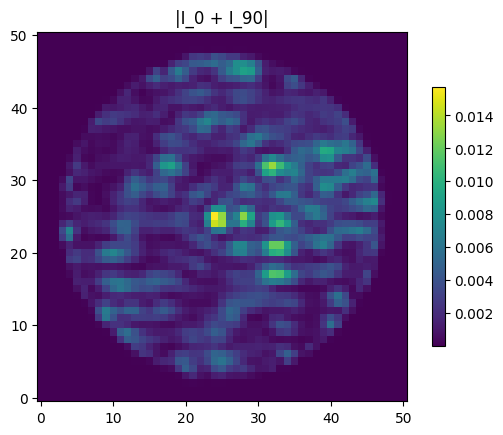

In [9]:
plt.imshow(image_tot_corgi_horizontal + image_tot_corgi_vertical, origin='lower')
plt.title('|I_0 + I_90|')

co = plt.colorbar(shrink=0.7)